<a href="https://colab.research.google.com/github/suleman12344/Final_YearProject/blob/main/Model/finalYear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall --quiet -y numpy pandas tensorflow
!pip install --quiet numpy==1.24.3 pandas==2.2.2 tensorflow==2.17.0
!pip install --quiet torch torchvision opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
pymc 5.19.1 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.


In [ ]:
import os
DATASET_PATH = '/content/drive/MyDrive/cubicasa5k'

if os.path.exists(DATASET_PATH):
    print('Dataset exists')
else:
    print('Dataset does not exist')

Dataset exists


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image

class FloorplanDataset(Dataset):
    def __init__(self, txt_file, base_dir, transform=None):
        """
        Args:
            txt_file (str): Path to the text file (e.g., train.txt).
            base_dir (str): Path to the base directory (e.g., high_quality).
            transform (callable, optional): Transform to apply to the images.
        """
        self.base_dir = base_dir
        self.transform = transform

        # Read the text file and generate a list of all image paths
        with open(txt_file, 'r') as file:
            folders = [line.strip() for line in file.readlines()]

        self.image_files = []
        for folder in folders:
            folder_path = base_dir+folder#os.path.join(base_dir, folder)

            self.image_files += [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Center crop the image to a fixed size after applying the transforms
        image = transforms.CenterCrop((256, 256))(image)  # Ensure consistent size

        return image, 0

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])


In [ ]:
train_path = "/content/drive/MyDrive/cubicasa5k/train.txt"
train_dataset = FloorplanDataset(txt_file=train_path, base_dir=DATASET_PATH, transform=transform)
test_path = "/content/drive/MyDrive/cubicasa5k/test.txt"
test_dataset = FloorplanDataset(txt_file=test_path, base_dir=DATASET_PATH, transform=transform)
val_path = "/content/drive/MyDrive/cubicasa5k/val.txt"
val_dataset = FloorplanDataset(txt_file=val_path, base_dir=DATASET_PATH, transform=transform)

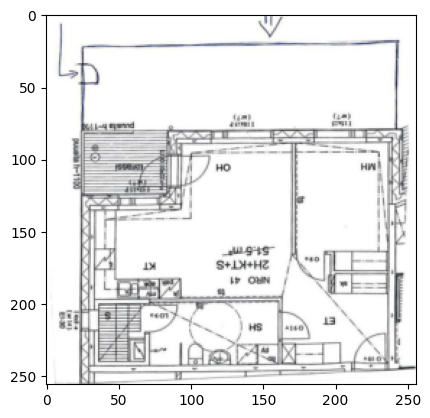

In [ ]:
from matplotlib import pyplot as plt

sample_image, _ = train_dataset[100]  # Unpack the tuple
plt.imshow(sample_image.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize for visualization
plt.show()

In [ ]:
latent_dim = 100
batch_size = 64
lr = 0.0002
beta1 = 0.5
epochs = 5
sample_interval = 100

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(train_loader)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch.nn as nn
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
           )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(0,1), #placeholder, updated in forward()
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        # Calculate the size dynamically based on the input
        linear_input_size = x.view(x.size(0), -1).shape[1]
        self.linear[1] = nn.Linear(linear_input_size, 1)  # update the linear layer
        return self.linear(x)

In [ ]:
# Initialize models and optimizers
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [ ]:
os.makedirs("generated_images", exist_ok=True)

In [ ]:
# Training loop
from torchvision.utils import save_image
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        if isinstance(real_images, tuple):
            real_images = real_images[0]  # Handle cases where the dataset returns nested tuples
        batch_size = real_images.size(0)

        # Skip batch if too small for BatchNorm
        if batch_size < 2:
            continue

        real_images = real_images.to(device)
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train discriminator
        optimizer_D.zero_grad()
        real_preds = discriminator(real_images)
        real_loss = criterion(real_preds, real_labels)

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        fake_preds = discriminator(fake_images.detach())
        fake_loss = criterion(fake_preds, fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()
        fake_preds = discriminator(fake_images)
        g_loss = criterion(fake_preds, real_labels)
        g_loss.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
        optimizer_G.step()

        # Logging
        if i % sample_interval == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
            save_image(fake_images[:25], f"generated_images/sample_{epoch+1}_{i+1}.png", nrow=5, normalize=True)

# Save models
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")
print("Training complete. Models saved as 'generator.pth' and 'discriminator.pth'.")

Epoch [1/5], Step [1/162], D Loss: 1.2295, G Loss: 0.3476
